#Paquetes necesarios

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la corespondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

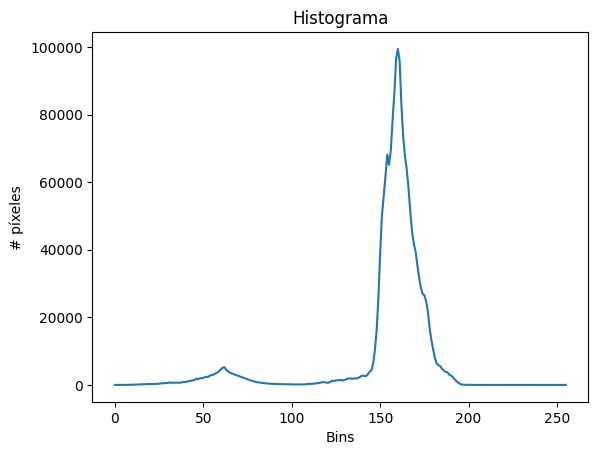

In [2]:
#Vizaulización del histograma de la imagen MonedasPropias.jpg, para elegir el umbral
img = cv2.imread('MonedasPropias.jpg')
monedas_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([monedas_gris], [0], None, [256], [0, 256])

plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)

Umbral fijo usado  120.0
Umbral Otsu  110.0


Text(0.5, 1.0, 'OTSU invertida')

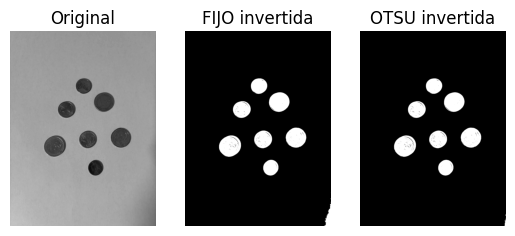

In [3]:
#Selección del umbral

#Opción 1: Umbralizado fijo
umbral = 120
th1,img_th1 = cv2.threshold(monedas_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)

#Opción 2: Umbralizado con Otsu
th2,img_th2 = cv2.threshold(monedas_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(monedas_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

C:\Users\Santiago\AppData\Local\Temp\ipykernel_8988\2336898421.py:70: RuntimeWarning: overflow encountered in scalar subtract
  if np.sqrt((x_original - x_circulo) ** 2 + (y_original - y_circulo) ** 2) <= radio:


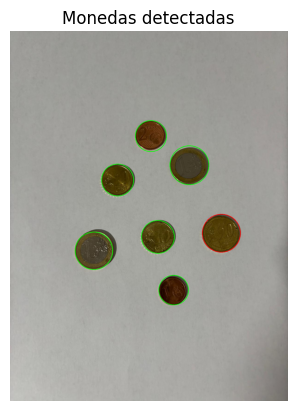

El valor de la moneda seleccionada es de:  1.0
Número de monedas: 7
Monedas de 1.00€: 3
Monedas de 0.10€: 3
Monedas de 0.02€: 1
Valor total de las monedas: 3.32€


In [4]:
#Detección de monedas con el umbral de Otsu

#Convertir la imagen original a escala de grises
monedas_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Aplicar un desenfoque Gaussiano para reducir el ruido y suavizar la imagen
pimg = cv2.GaussianBlur(monedas_gris, (9, 9), 2)
edges = cv2.Canny(pimg, 50, 150)

monedas_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Redimensionar la imagen para que se muestre correctamente en la pantalla
width = int(monedas_rgb.shape[1] * 0.5)
height = int(monedas_rgb.shape[0] * 0.5)
dim = (width, height)
img_resized = cv2.resize(monedas_rgb, dim, cv2.INTER_AREA)

#Factor de escala para convertir las coordenadas de la imagen redimensionada a la original
escala_X = img.shape[1] / img_resized.shape[1]
escala_Y = img.shape[0] / img_resized.shape[0]

#Detectar círculos en la imagen usando el método Hough Circle Transform
circ = cv2.HoughCircles(
    edges,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=50,
    param1=100,
    param2=30,
    minRadius=30,
    maxRadius=200
)

#Diccionario con los radios aproximados de las monedas y su valor en euros
valor_monedas = {
    12.875: 2.00,
    11.625: 1.00,
    11.125: 0.20,
    9.875: 0.10,
    9.375: 0.02,
    8.125: 0.01
}

#Variables para almacenar la moneda seleccionada y el conteo de monedas
monedaEscogida = None
conteo_monedas = {valor: 0 for valor in valor_monedas.values()}

#Factor de escala para convertir los radios de los círculos a milímetros
factor_escala = (23.25 / 2) / 82
margen_error = 0.75

#Función para manejar el evento de clic del ratón
def click_event(event, x, y, flags, param):
    global monedaEscogida, img_resized, circ, conteo_monedas
    if event == cv2.EVENT_LBUTTONDOWN:
        #Convertir las coordenadas de la imagen redimensionada a la original
        x_original = int(x * escala_X)
        y_original = int(y * escala_Y)

        #Si se detectaron círculos en la imagen
        if circ is not None:
            #Redondear las coordenadas y el radio de los círculos
            circulos = np.uint16(np.around(circ))

            #Buscar si el clic del ratón está dentro de un círculo
            for i, circulo in enumerate(circulos[0, :]):
                x_circulo, y_circulo, radio = circulo

                #Si el clic del ratón está dentro del círculo, seleccionar la moneda
                if np.sqrt((x_original - x_circulo) ** 2 + (y_original - y_circulo) ** 2) <= radio:
                    monedaEscogida = circulo
                    break

        find_coins(monedaEscogida)
        conteo_monedas = {valor: 0 for valor in valor_monedas.values()} #Reiniciar el conteo de monedas

#Función para encontrar las monedas en la imagen
def find_coins(moneda):
    valor_total = 0.0
    if circ is not None:
        #Redondear los círculos
        circulos = np.uint16(np.around(circ))
        contador_monedas = 0

        valor_seleccionado = 0
        for circulo in circulos[0, :]:
            #Dibujar los círculos en la imagen
            x, y, radio = circulo
            cv2.circle(img, (x, y), radio, (0, 255, 0), 2)
            cv2.circle(img, (moneda[0], moneda[1]), moneda[2], (0, 0, 255), 2)

            #Calcular el radio de la moneda en milímetros
            radio_en_mm = radio * factor_escala
            radio_en_mm_selected = moneda[2] * factor_escala

            valor_moneda = 0
            for r in valor_monedas.keys():
                #Si el radio de la moneda está dentro de un margen de error, asignar el valor de la moneda
                if r - margen_error <= round(radio_en_mm, 3) <= r + margen_error:
                    #Si el radio coincide con la moneda seleccionada, guardar su valor
                    if radio_en_mm == radio_en_mm_selected:
                        valor_seleccionado = valor_monedas[r]

                    valor_moneda = valor_monedas[r]     #Asignar el valor de la moneda detectada
                    conteo_monedas[valor_moneda] += 1   #Incrementar el conteo de monedas
                    break

            #Sumar el valor de la moneda al valor total y contar el número de monedas
            valor_total += valor_moneda
            contador_monedas += 1

        #Mostrar la imagen con los círculos dibujados
        plt.axis("off")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Monedas detectadas')
        plt.show()

        #Imprimir el valor de la moneda seleccionada, el número de monedas y el valor total
        print("El valor de la moneda seleccionada es de: ", valor_seleccionado)
        print(f'Número de monedas: {contador_monedas}')
        for valor, cantidad in conteo_monedas.items():
            if cantidad > 0:
                print(f'Monedas de {valor:.2f}€: {cantidad}')
        print(f'Valor total de las monedas: {valor_total:.2f}€')
    else:
        print('No existen monedas en la imagen')

#Mostrar la imagen redimensionada con los círculos dibujados
cv2.imshow("Monedas", cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
cv2.setMouseCallback("Monedas", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [10]:
vid = cv2.VideoCapture(0)

valor_monedas = {
    12.875: 2.00,
    11.625: 1.00,
    11.125: 0.20,
    9.875: 0.10,
    9.375: 0.02,
    8.125: 0.01
}

conteo_monedas = {valor: 0 for valor in valor_monedas.values()}
valor_total = 0.0

factor_escala = (23.25 / 2) / 82

margen_error = 0.75

mode = 0
frame_copied = False

while True:
    ret, frame = vid.read()
    if mode == 1 and not frame_copied:
        frame_copy = frame.copy()
        frame_copied = True
        frame_gris = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2GRAY)
        pimg = cv2.GaussianBlur(frame_gris, (9, 9), 2)

        monedas_rgb = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)

        edges = cv2.Canny(pimg, 30, 120)

        circ = cv2.HoughCircles(
            edges,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=50,
            param1=100,
            param2=30,
            minRadius=10,
            maxRadius=300
        )
        
        if circ is not None:
            circulos = np.uint16(np.around(circ))
            contador_monedas = 0

            for circulo in circulos[0, :]:
                x, y, radio = circulo
                zona = frame_copy[y - radio:y + radio, x - radio:x + radio]

                altura, ancho, _ = zona.shape
                if altura > 0 and ancho > 0:
                    relacion_aspecto = ancho / altura
                    if 0.9 < relacion_aspecto < 1.1:
                        contador_monedas += 1
                        cv2.circle(frame_copy, (x, y), radio, (0, 255, 0), 2)
                        radio_en_mm = radio * factor_escala
                        valor_moneda = 0
                        for r in valor_monedas.keys():
                            if r - margen_error <= round(radio_en_mm, 3) <= r + margen_error:
                                valor_moneda = valor_monedas[r]
                                conteo_monedas[valor_moneda] += 1
                                break
                        valor_total += valor_moneda

        plt.axis("off")
        plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
        plt.title('Monedas detectadas')
        plt.show()
        print(f'Número de monedas: {contador_monedas}')
        for valor, cantidad in conteo_monedas.items():
            if cantidad > 0:
                print(f'Monedas de {valor:.2f}€: {cantidad}')
        print(f'Valor total de las monedas: {valor_total:.2f}€')

    cv2.imshow('Cam', frame)

    tecla = cv2.waitKey(20)
    if tecla == 27:
        break
    elif tecla == ord('1'):
        contador_monedas = 0
        frame_copied = False
        mode = 1
    elif tecla == ord('2'):
        mode = 0

vid.release()
cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Text(0.5, 1.0, 'Alquitrán')

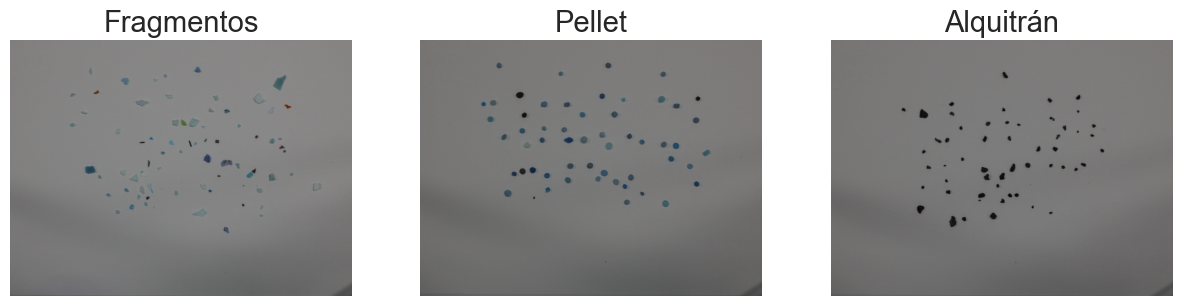

In [21]:
#Se cargan las imágenes
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
alqui = cv2.imread('tar-03-olympus-10-01-2020.JPG')

#Mostramos
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.axis("off")
plt.imshow(frag)
plt.title('Fragmentos')

plt.subplot(132)
plt.axis("off")
plt.imshow(pellet)
plt.title('Pellet')

plt.subplot(133)
plt.axis("off")
plt.imshow(alqui)
plt.title('Alquitrán')


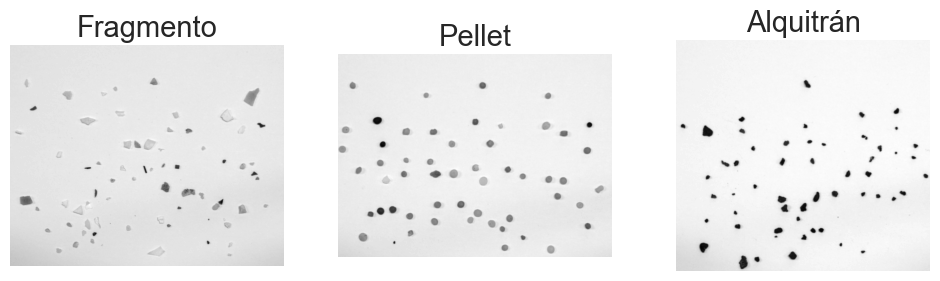

In [22]:
#Secciones sobre las que trabajar
recorte_frag = (slice(0, 2500), slice(900, 4000))
recorte_pellets = (slice(0, 2300), slice(900, 4000))
recorte_tar = (slice(0, 2550), slice(900, 3700))

# Recortar y normalizar las imágenes
def preprocesar_imagen(imagen, recorte):
    #Recortar
    imagen_recortada = imagen[recorte]
    #Convertir a escala de grises
    imagen_gris = cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2GRAY)
    #Normalizar entre 0 y 255
    imagen_norm = cv2.normalize(imagen_gris, None, 0, 255, cv2.NORM_MINMAX)
    #Suavizar
    imagen_suave = cv2.GaussianBlur(imagen_norm, (15, 15), 0)
    return imagen_suave

frag_gris = preprocesar_imagen(frag, recorte_frag)
pellet_gris = preprocesar_imagen(pellet, recorte_pellets)
alqui_gris = preprocesar_imagen(alqui, recorte_tar)

# Mostrar las imágenes preprocesadas
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Fragmentos')
plt.axis("off")
plt.imshow(frag_gris, cmap='gray')

plt.subplot(132)
plt.title('Pellets')
plt.axis("off")
plt.imshow(pellet_gris, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_gris, cmap='gray')
plt.show()

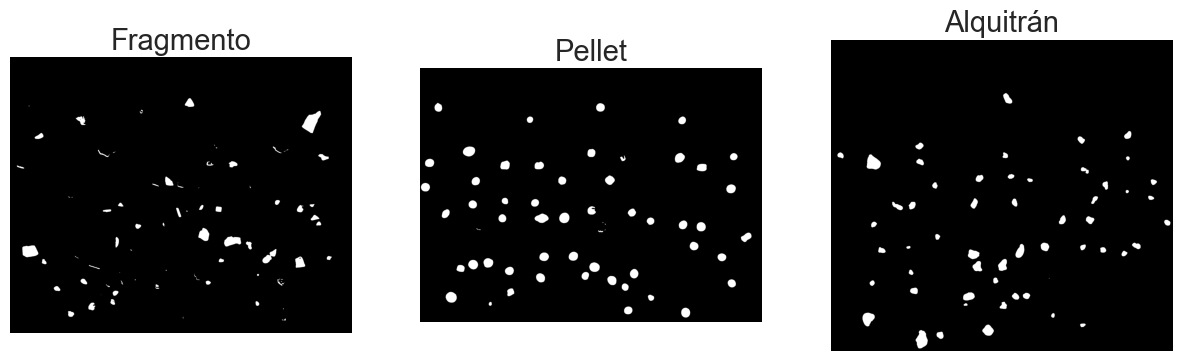

In [26]:
def segmentar_imagen(imagen):
    #Detección de bordes
    bordes = cv2.Canny(imagen, 100, 200)
    #Umbral adaptativo
    umbral_adapt = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    return umbral_adapt

frag_segmentada = segmentar_imagen(frag_gris)
pellet_segmentada = segmentar_imagen(pellet_gris)
alqui_segmentada = segmentar_imagen(alqui_gris)

#Mostrar imágenes segmentadas
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(frag_segmentada, cmap='gray')

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pellet_segmentada, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_segmentada, cmap='gray')
plt.show()

In [30]:
def clasificar(imagen_segmentada):
    contornos, _ = cv2.findContours(imagen_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clasificaciones = {'fragmentos': 0, 'pellets': 0, 'alquitran': 0}
    
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        _, _, w, h = cv2.boundingRect(contorno)
        if area > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        relacion_aspecto = w / h
        
        if compacidad < 15 and np.isclose(relacion_aspecto, 1.0, atol=0.1):
            clasificaciones['pellets'] += 1
        elif relacion_aspecto > 1.2:
            clasificaciones['fragmentos'] += 1
        else:
            clasificaciones['alquitran'] += 1
    
    return clasificaciones

frag_clasif = clasificar(frag_segmentada)
pellet_clasif = clasificar(pellet_segmentada)
alqui_clasif = clasificar(alqui_segmentada)
totales = {'fragmentos': frag_clasif["fragmentos"] + pellet_clasif["fragmentos"] + alqui_clasif["fragmentos"],
            'pellets': frag_clasif["pellets"] + pellet_clasif["pellets"] + alqui_clasif["pellets"],
            'alquitran': frag_clasif["alquitran"] + pellet_clasif["alquitran"] + alqui_clasif["alquitran"]}

print("Clasificación Fragmentos:", frag_clasif)
print("Clasificación Pellets:", pellet_clasif)
print("Clasificación Alquitrán:", alqui_clasif)
print("Totales:", totales)

Clasificación Fragmentos: {'fragmentos': 42, 'pellets': 2, 'alquitran': 41}
Clasificación Pellets: {'fragmentos': 7, 'pellets': 36, 'alquitran': 14}
Clasificación Alquitrán: {'fragmentos': 13, 'pellets': 10, 'alquitran': 32}
Totales: {'fragmentos': 62, 'pellets': 48, 'alquitran': 87}


Particulas reales:  197


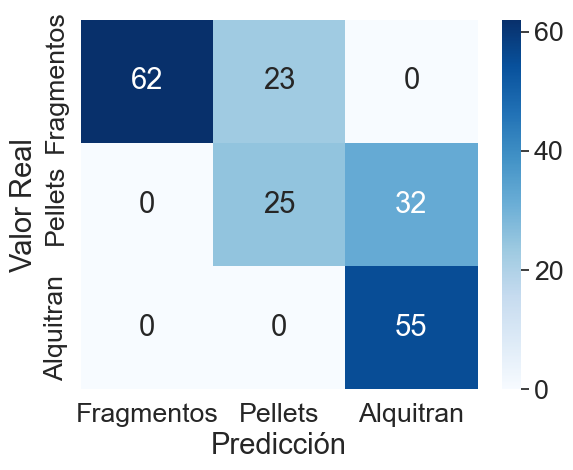

In [47]:
# Construir matriz de confusión a partir de los resultados
contornos_fragmentos, _ = cv2.findContours(frag_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos_pellets, _ = cv2.findContours(pellet_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos_tars, _ = cv2.findContours(alqui_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contornos_reales_fragmentos = len(contornos_fragmentos)
contornos_reales_pellets = len(contornos_pellets)
contornos_reales_tar = len(contornos_tars)


y_true = ['fragmentos'] * contornos_reales_fragmentos + ['pellets'] * contornos_reales_pellets + ['alquitran'] * contornos_reales_tar
y_pred = ['fragmentos'] * totales['fragmentos'] + ['pellets'] * totales['pellets'] + ['alquitran'] * totales['alquitran']

matriz_confusion = confusion_matrix(y_true, y_pred, labels=['fragmentos', 'pellets', 'alquitran'])

# Mostrar matriz de confusión
sns.set(font_scale = 1.75)
sns.heatmap(matriz_confusion, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Fragmentos', 'Pellets', 'Alquitran'],
            yticklabels=['Fragmentos', 'Pellets', 'Alquitran'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()